In [133]:
import os
import time
import obspy
import matplotlib.pyplot as plt
# Load the trained model
import seisbench.models as sbm
import seisbench.data as sbd
import torch
# Convert a ndarray to a stream (only values)
from scipy.stats import norm
import numpy as np
from obspy import Stream, Trace
from obspy import UTCDateTime

### 1. Load the dataset (metadata): before + after

In [113]:
# 1) Load the metadata before filtering
train_dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering/train_dataset/"
val_dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering/val_dataset/"
test_dataset_base_path_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/before_filtering/test_dataset/"
train_dataset_before = sbd.WaveformDataset(train_dataset_base_path_before, component_order="ENZ")
val_dataset_before = sbd.WaveformDataset(val_dataset_base_path_before, component_order="ENZ")
test_dataset_before = sbd.WaveformDataset(test_dataset_base_path_before, component_order="ENZ")
print(f"Dataset before filtering loaded successfully.Total files={len(train_dataset_before) + len(val_dataset_before) + len(test_dataset_before)}")

# 2) Load the metadata after filtering
train_dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering/train_dataset/"
val_dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering/val_dataset/"
test_dataset_base_path_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/after_filtering/test_dataset/"
train_dataset_after = sbd.WaveformDataset(train_dataset_base_path_after, component_order="ENZ")
val_dataset_after = sbd.WaveformDataset(val_dataset_base_path_after, component_order="ENZ")
test_dataset_after = sbd.WaveformDataset(test_dataset_base_path_after, component_order="ENZ")
print(f"Dataset after filtering loaded successfully. Total files={len(train_dataset_after) + len(val_dataset_after) + len(test_dataset_after)}")

# 3) Define the stream files directory
stream_files_dir_before = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_before_filtering/"
stream_files_dir_after = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_highpass_3HZ/"

2024-06-15 20:04:03,820 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-15 20:04:03,981 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-15 20:04:04,038 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.


Dataset before filtering loaded successfully.Total files=111836


2024-06-15 20:04:04,430 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-15 20:04:04,570 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-06-15 20:04:04,619 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.


Dataset after filtering loaded successfully. Total files=111836


### 2. Load the 4 trained models + base model: origianl before + after; pre-trained before + after

In [187]:
# 1) Original model before filtering
original_model_before_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/60epochs_model_before_filtering.pt"
orginal_model_before = sbm.PhaseNet(phases="PSN", norm="peak")
orginal_model_before.load_state_dict(torch.load(original_model_before_path))

# 2) Original model after filtering
original_model_after_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/60epochs_model_after_highpass.pt"
orginal_model_after = sbm.PhaseNet(phases="PSN", norm="peak")
orginal_model_after.load_state_dict(torch.load(original_model_after_path))

# 3) Pre-trained model before filtering
pretrained_model_before_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/pre_60epochs_model_before_filtering.pt"
pretrained_model_before = sbm.PhaseNet(phases="PSN", norm="peak")
pretrained_model_before.load_state_dict(torch.load(pretrained_model_before_path))

# 4) Pre-trained model after filtering
pretrained_model_after_path = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/Seisbench_Dataset/saved_models/pre_60epochs_model_after_highpass.pt"
pretrained_model_after = sbm.PhaseNet(phases="PSN", norm="peak")
pretrained_model_after.load_state_dict(torch.load(pretrained_model_after_path))

print("4 Models loaded successfully.")

############ Base model ############
base_model = sbm.PhaseNet.from_pretrained("original")

print("Base model loaded successfully.")

4 Models loaded successfully.
Base model loaded successfully.


### 3. Define a classification and visualization function

In [173]:
def classify_and_record(model, meta, stream_files_dir, threshold_p, threshold_s):
    # 0) Initialize the list of errors
    p_errors = []
    s_errors = []
    p_correct_count = 0  # error < threshold
    s_correct_count = 0  # error < threshold
    
    # 1) Loop over the metadata
    for m in range(len(meta)):
        # 1.1) Obtain the necessary information
        # Get the current true information from the metadata
        trace_file_name = os.path.join(stream_files_dir, meta['trace_name_original'][m])
        trace_sampling_rate = meta['trace_sampling_rate_hz'][m]      # Unit: Hz
        trace_start_time = UTCDateTime(meta['trace_start_time'][m])  # Unit: UTCDateTime
        trace_p_arrival_sample = meta['trace_p_arrival_sample'][m]   # Unit: sample (index) 
        trace_s_arrival_sample = meta['trace_s_arrival_sample'][m]   # Unit: sample (index)
        # Convert from sample to time
        trace_p_arrival_time = trace_start_time + trace_p_arrival_sample / trace_sampling_rate  # Unit: UTCDateTime
        trace_s_arrival_time = trace_start_time + trace_s_arrival_sample / trace_sampling_rate  # Unit: UTCDateTime
        
        # 1.2) Load the stream and predictions 
        stream = obspy.read(trace_file_name)
        picks = model.classify(stream).picks
        
        # 1.3) Classification and record: Loop over the picks
        for pick in picks:
            # Convert each pick to a dictionary
            pick_dict = pick.__dict__
            # Extract 'phase' and 'peak_time' information of the prediction 
            phase = pick_dict['phase']
            peak_time = pick_dict['peak_time']                                         # Unit: UTCDateTime
            # peak_time_sample = (peak_time - trace_start_time) * trace_sampling_rate  # Unit: sample (index)
            # 1.2.1) P-phase
            if phase == 'P':
                # Calculate the error
                p_error = trace_p_arrival_time - peak_time  # Unit: UTCDateTime
                if abs(p_error) < threshold_p:
                    p_errors.append(p_error)
                    p_correct_count += 1
            # 1.2.2) S-phase
            elif phase == 'S':
                # Calculate the error
                s_error = trace_s_arrival_time - peak_time  # Unit: UTCDateTime
                if abs(s_error) < threshold_s:
                    s_errors.append(s_error)
                    s_correct_count += 1
                    
    # 3) Return the results
    results_dict = {
        # Parameters
        'threshold_p': threshold_p,
        'threshold_s': threshold_s,
        'total_samples': len(meta),
        'sampling_rate': trace_sampling_rate,
        # Results
        'p_errors': p_errors,
        's_errors': s_errors,
        'p_correct_count': p_correct_count,
        's_correct_count': s_correct_count
    }
    return results_dict
    

In [180]:
def plot_histograms(results_dict, filename):
    p_errors = results_dict['p_errors']
    s_errors = results_dict['s_errors']

    # Calculate mean and standard deviation for P and S errors
    p_mean, p_std = np.mean(p_errors), np.std(p_errors)
    s_mean, s_std = np.mean(s_errors), np.std(s_errors)

    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Left panel: P-phase histogram with Gaussian fit
    ax1 = axes[0]
    ax2 = ax1.twinx()
    counts, bins, patches = ax1.hist(p_errors, bins=20, color='blue', edgecolor='black', alpha=0.7, label='P Errors')
    x = np.linspace(min(p_errors), max(p_errors), 100)
    p_pdf = norm.pdf(x, p_mean, p_std)
    ax2.plot(x, p_pdf, 'k--', linewidth=2, label='Gaussian Fit')
    p_title = (f"Prediction Errors for P Phase on Test Dataset.\n"
               f"P Threshold={results_dict['threshold_p']}s, Accurate Count={results_dict['p_correct_count']}, "
               f"Accuracy={results_dict['p_correct_count']/results_dict['total_samples']*100:.2f}%\n"
               f"Gaussian fit: Mean={p_mean:.2f}, Std Dev={p_std:.2f}")
    ax1.set_title(p_title)
    ax1.set_xlabel('Error [s]')
    ax1.set_ylabel('Count')
    ax2.set_ylabel('Density')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Right panel: S-phase histogram with Gaussian fit
    ax1 = axes[1]
    ax2 = ax1.twinx()
    counts, bins, patches = ax1.hist(s_errors, bins=20, color='red', edgecolor='black', alpha=0.7, label='S Errors')
    x = np.linspace(min(s_errors), max(s_errors), 100)
    s_pdf = norm.pdf(x, s_mean, s_std)
    ax2.plot(x, s_pdf, 'k--', linewidth=2, label='Gaussian Fit')
    s_title = (f"Prediction Errors for S Phase on Test Dataset.\n"
               f"S Threshold={results_dict['threshold_s']}s, Accurate Count={results_dict['s_correct_count']}, "
               f"Accuracy={results_dict['s_correct_count']/results_dict['total_samples']*100:.2f}%\n"
               f"Gaussian fit: Mean={s_mean:.2f}, Std Dev={s_std:.2f}")
    ax1.set_title(s_title)
    ax1.set_xlabel('Error [s]')
    ax1.set_ylabel('Count')
    ax2.set_ylabel('Density')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Display the plot
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

## 4. Call the classification and visualization functions for 4 models: different thresholds

### 4. Call the classification and visualization functions for 4 models: threshold_p=0.5s, threshold_s=0.5s

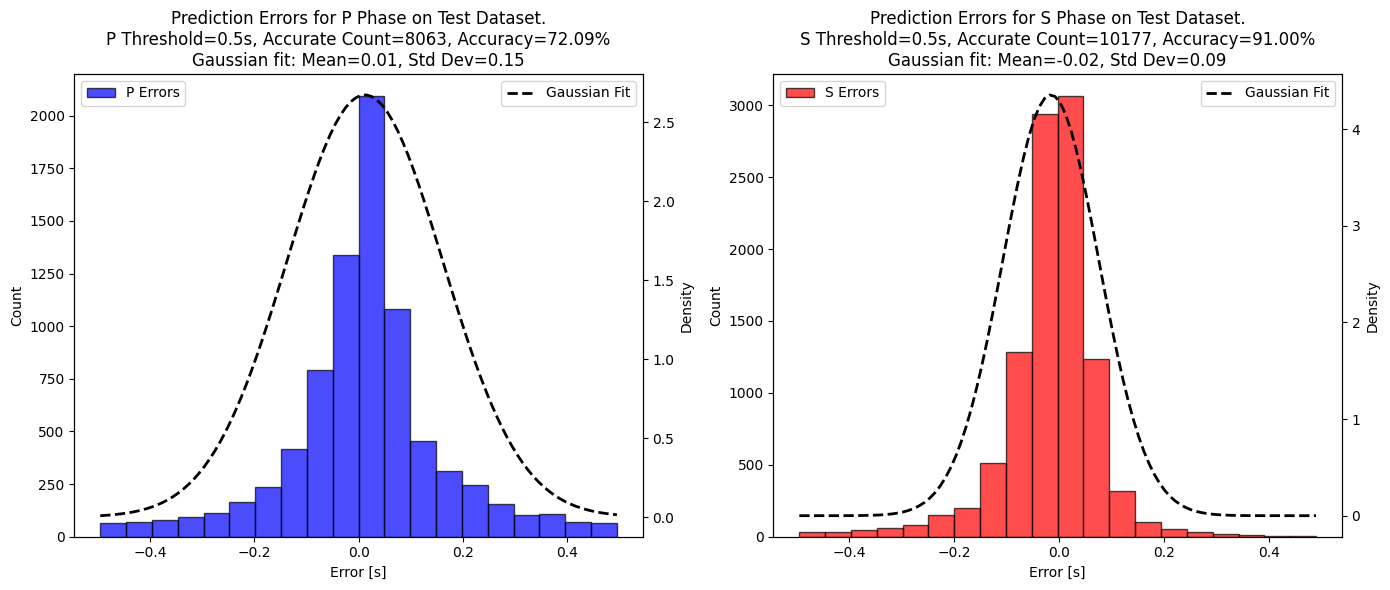

In [181]:
# 1) Original model before filtering: 6 parameters
model = orginal_model_before
meta = test_dataset_before.metadata
stream_files_dir = stream_files_dir_before
threshold_p = 0.5  # Unit: seconds
threshold_s = 0.5  # Unit: seconds
filename = f"hist_orig_model_before_{threshold_p}_second.png"
# Call the function
start_time = time.time()
results_dict_orig_before = classify_and_record(model=model, meta=meta, stream_files_dir=stream_files_dir, threshold_p=threshold_p, threshold_s=threshold_s)
end_time = time.time()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")
# Plot the histograms
plot_histograms(results_dict=results_dict_orig_before, filename=filename)

Time elapsed: 414.60 seconds.


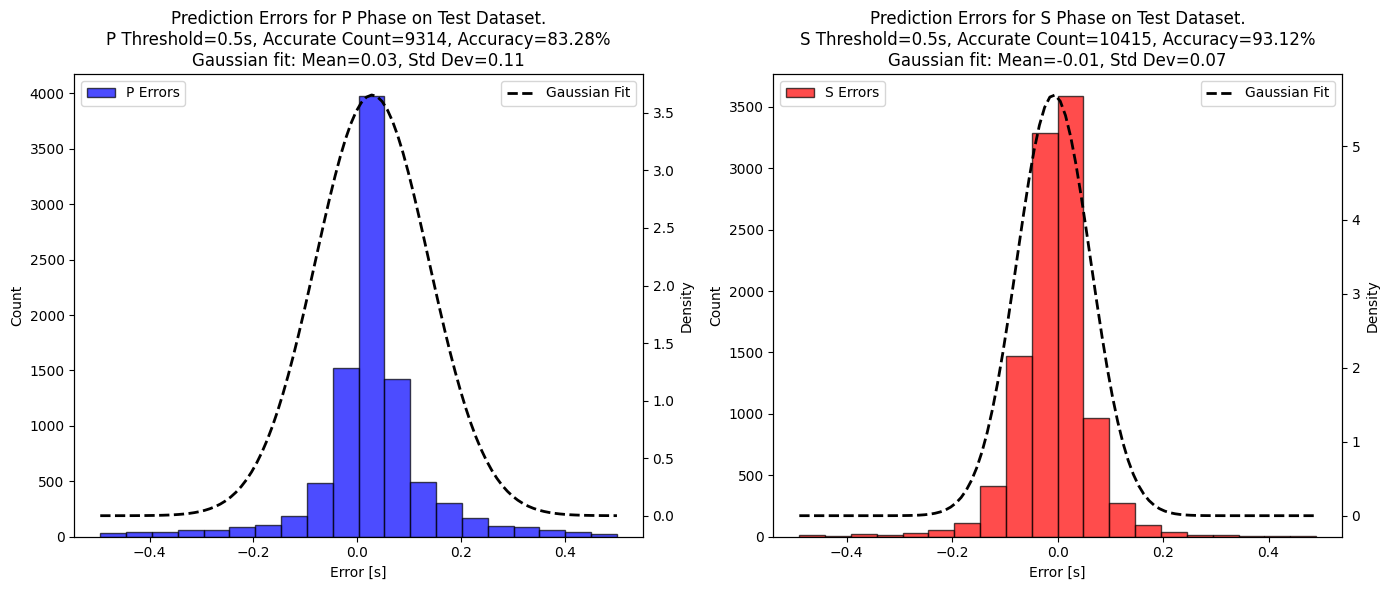

In [182]:
# 2) Original model after filtering: 6 parameters
model = orginal_model_after
meta = test_dataset_after.metadata
stream_files_dir = stream_files_dir_after
threshold_p = 0.5  # Unit: seconds
threshold_s = 0.5  # Unit: seconds
filename = f"hist_orig_model_after_{threshold_p}_second.png"
# Call the function
start_time = time.time()
results_dict_orig_after = classify_and_record(model=model, meta=meta, stream_files_dir=stream_files_dir, threshold_p=threshold_p, threshold_s=threshold_s)
end_time = time.time()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")
# Plot the histograms
plot_histograms(results_dict=results_dict_orig_after, filename=filename)

Time elapsed: 422.49 seconds.


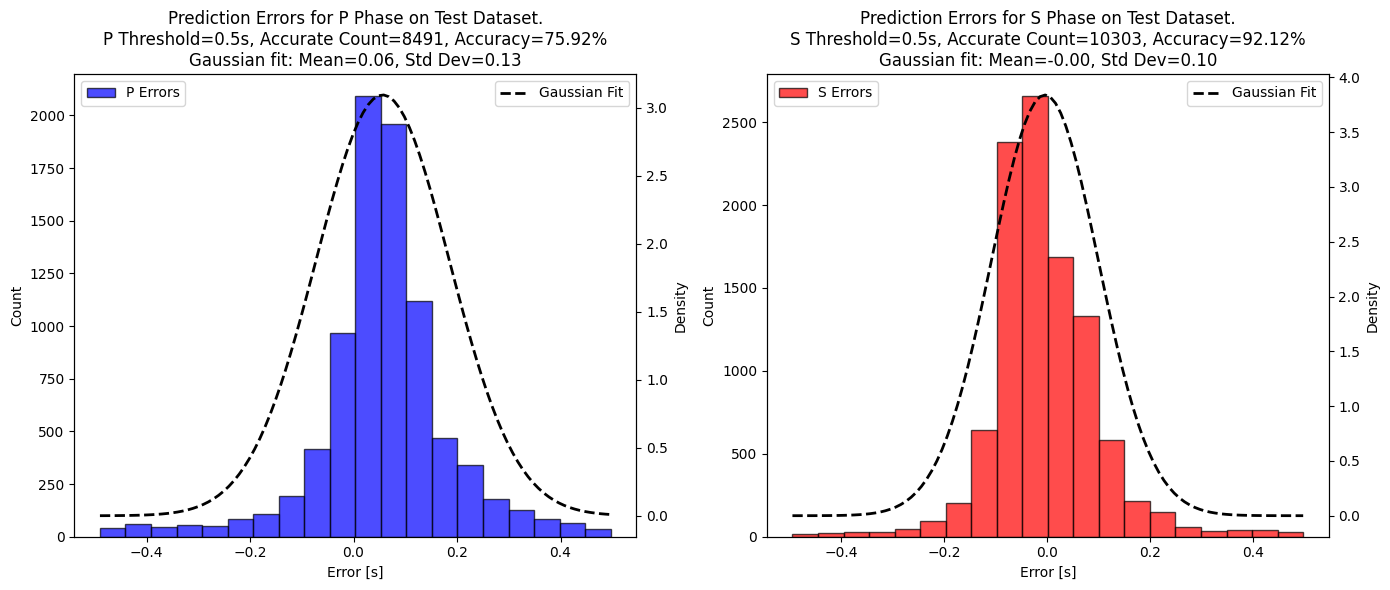

In [183]:
# 3) Pretrained model before filtering: 6 parameters: Transfer learning
model = pretrained_model_before
meta = test_dataset_before.metadata
stream_files_dir = stream_files_dir_before
threshold_p = 0.5  # Unit: seconds
threshold_s = 0.5  # Unit: seconds
filename = f"hist_pre_model_before_{threshold_p}_second.png"
# Call the function
start_time = time.time()
results_dict_pre_before = classify_and_record(model=model, meta=meta, stream_files_dir=stream_files_dir, threshold_p=threshold_p, threshold_s=threshold_s)
end_time = time.time()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")
# Plot the histograms
plot_histograms(results_dict=results_dict_pre_before, filename=filename)

Time elapsed: 488.45 seconds.


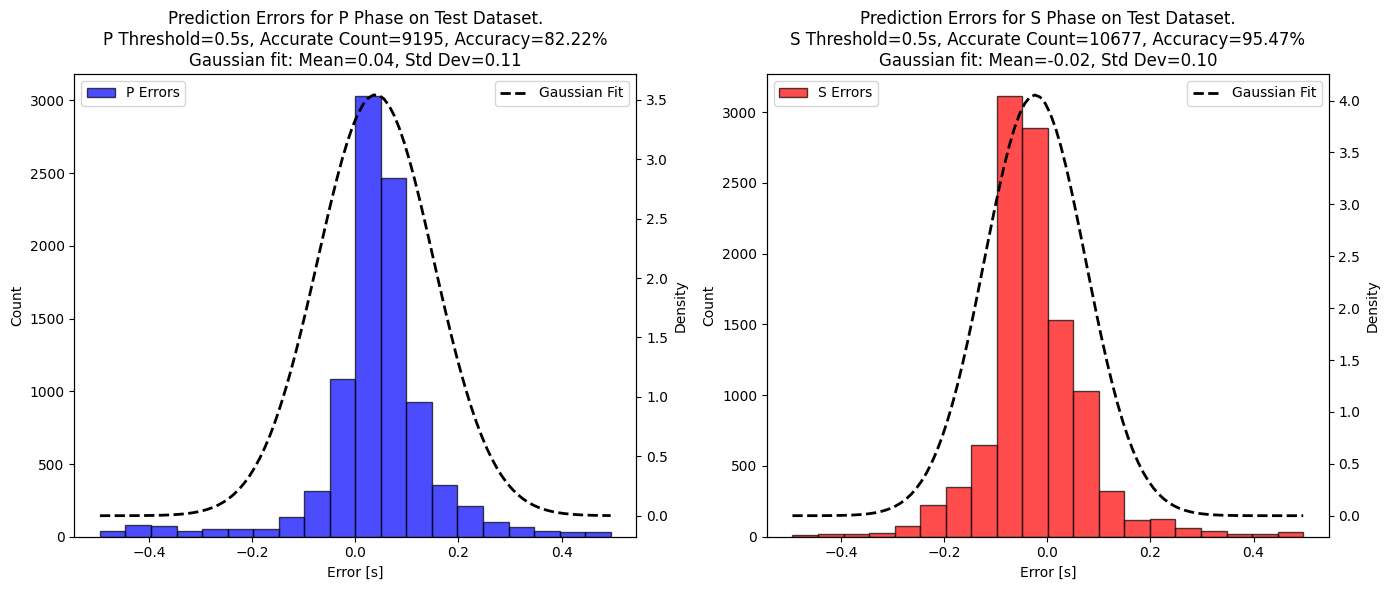

In [184]:
# 4) Pretrained model after filtering: 6 parameters
model = pretrained_model_after
meta = test_dataset_after.metadata
stream_files_dir = stream_files_dir_after
threshold_p = 0.5  # Unit: seconds
threshold_s = 0.5  # Unit: seconds
filename = f"hist_pre_model_after_{threshold_p}_second.png"
# Call the function
start_time = time.time()
results_dict_pre_after = classify_and_record(model=model, meta=meta, stream_files_dir=stream_files_dir, threshold_p=threshold_p, threshold_s=threshold_s)
end_time = time.time()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")
# Plot the histograms
plot_histograms(results_dict=results_dict_pre_after, filename=filename)

Time elapsed: 437.32 seconds.


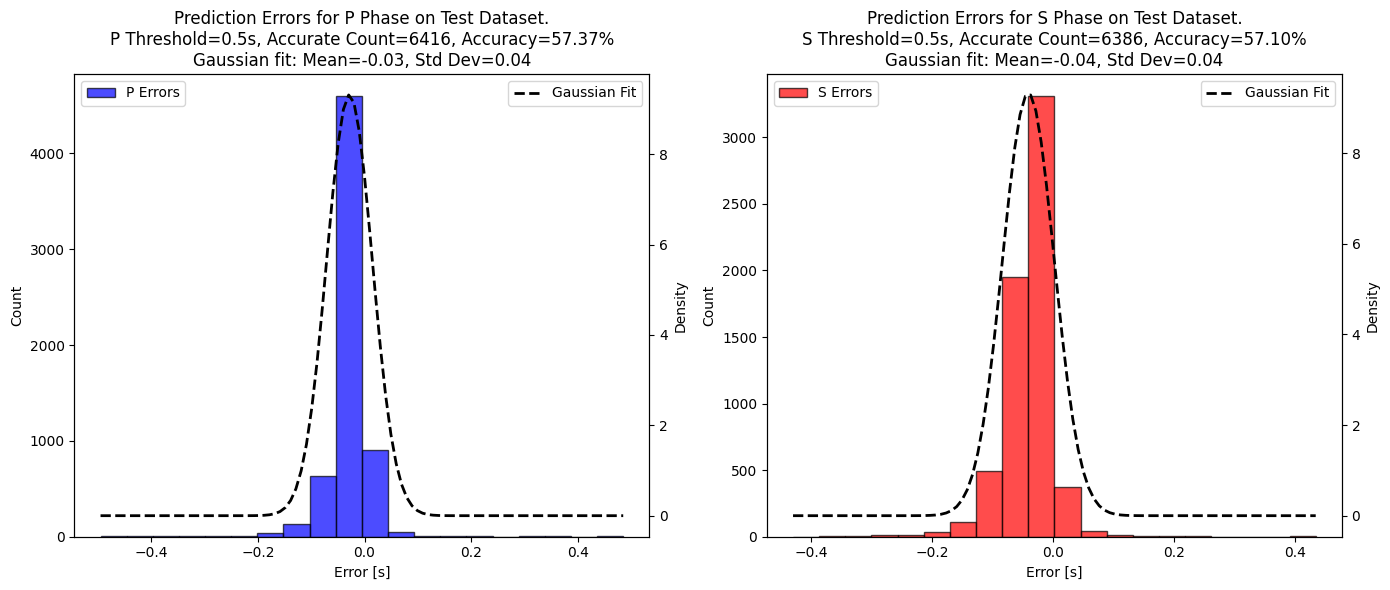

In [188]:
# 5) Base model before filtering: 6 parameters: Base model
model = base_model
meta = test_dataset_before.metadata
stream_files_dir = stream_files_dir_before
threshold_p = 0.5  # Unit: seconds
threshold_s = 0.5  # Unit: seconds
filename = f"hist_base_model_before_{threshold_p}_second.png"
# Call the function
start_time = time.time()
results_dict_base_before = classify_and_record(model=model, meta=meta, stream_files_dir=stream_files_dir, threshold_p=threshold_p, threshold_s=threshold_s)
end_time = time.time()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")
# Plot the histograms
plot_histograms(results_dict=results_dict_base_before, filename=filename)

Time elapsed: 437.61 seconds.


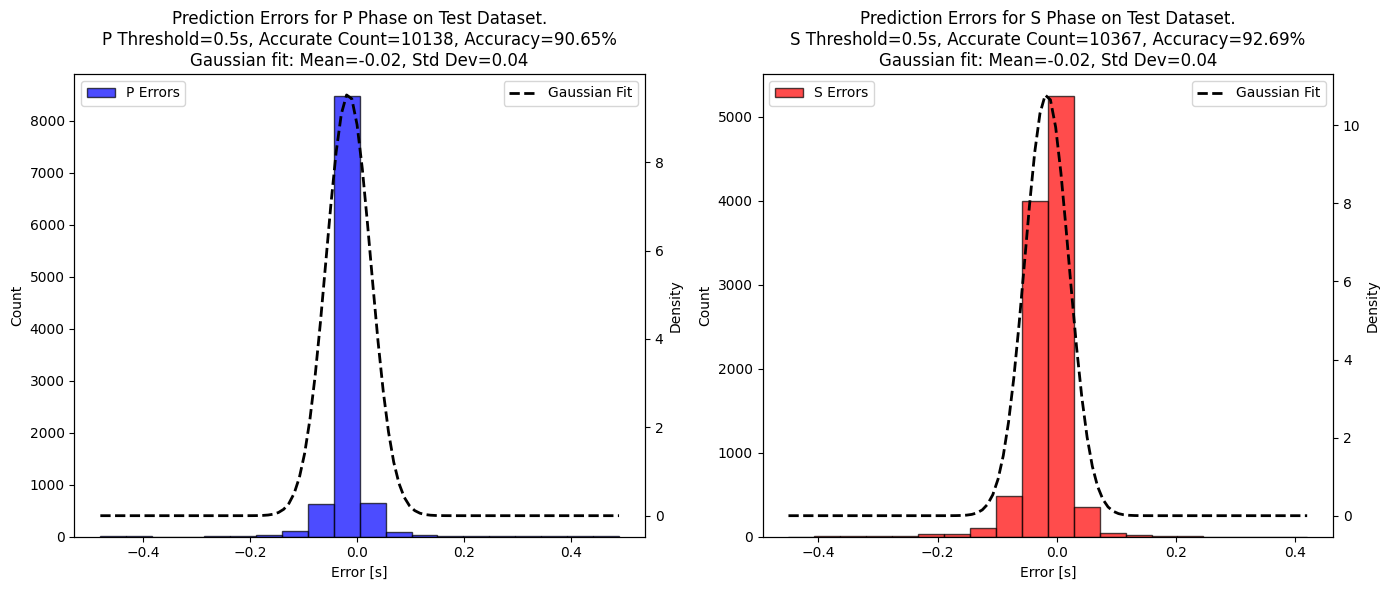

In [189]:
# 6) Base model after filtering: 6 parameters
model = base_model
meta = test_dataset_after.metadata
stream_files_dir = stream_files_dir_after
threshold_p = 0.5  # Unit: seconds
threshold_s = 0.5  # Unit: seconds
filename = f"hist_base_model_after_{threshold_p}_second.png"
# Call the function
start_time = time.time()
results_dict_base_after = classify_and_record(model=model, meta=meta, stream_files_dir=stream_files_dir, threshold_p=threshold_p, threshold_s=threshold_s)
end_time = time.time()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")
# Plot the histograms
plot_histograms(results_dict=results_dict_base_after, filename=filename)

### 5. Visualization: Dataset 

In [190]:
import random
def get_random_stream_file(directory):
    files = os.listdir(directory)
    chosen_file = None
    count = 0
    for file in files:
        count += 1
        if random.randint(1, count) == 1:
            # The file name 
            chosen_file = os.path.join(directory, file)
    # Return the chosen file
    return obspy.read(chosen_file)

#### 5.1 Base model

In [199]:
val_data_dir = "/home/edoardo2/ml3_transfer_learning/New_Dataset/coseismiq_data/data/seismic_before_filtering/"
stream_test = get_random_stream_file(val_data_dir)

Text(0.5, 1.0, 'Predicted P and S arrival times')

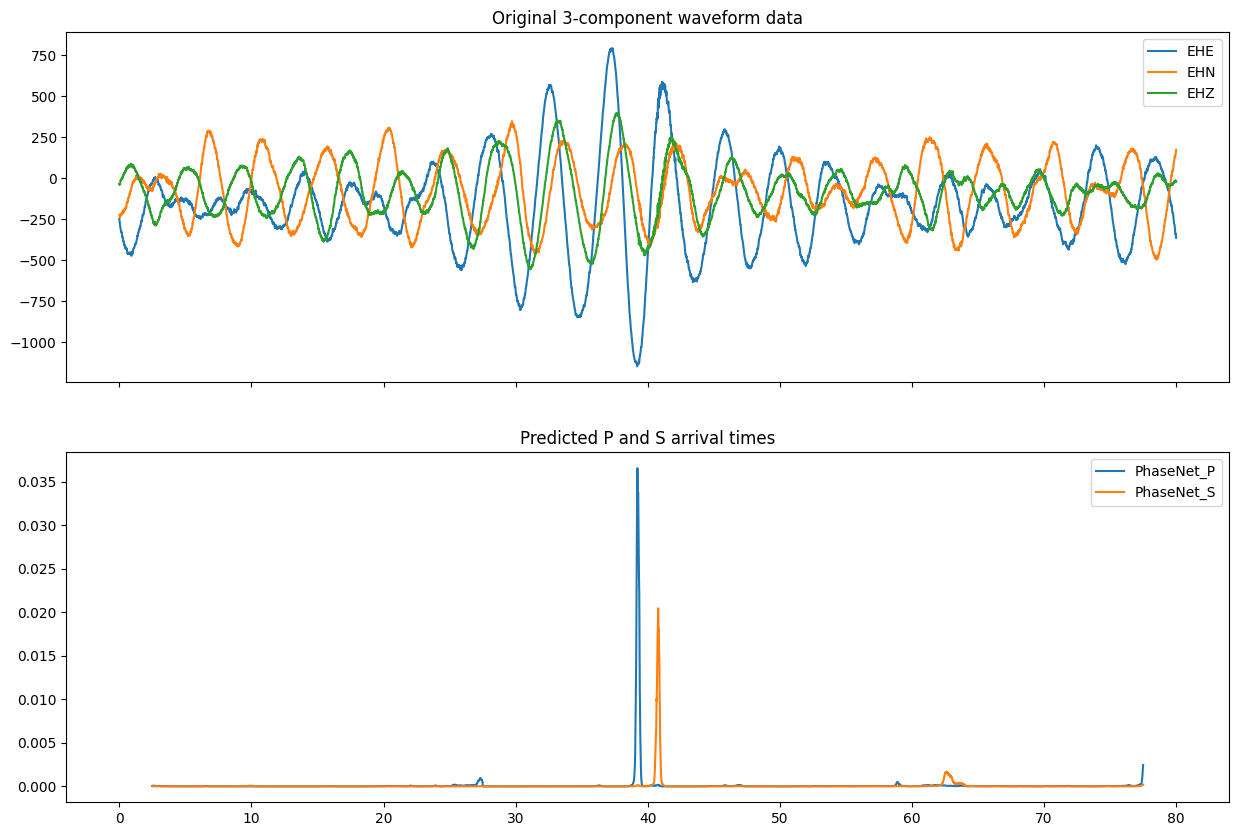

In [200]:
new_annotations = base_model.annotate(stream_test, overlap=2000)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = new_annotations[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if new_annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(new_annotations[i].times() + offset, new_annotations[i].data, label=new_annotations[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times")

#### 5.2 pretrained_model_after

Text(0.5, 1.0, 'Predicted P and S arrival times')

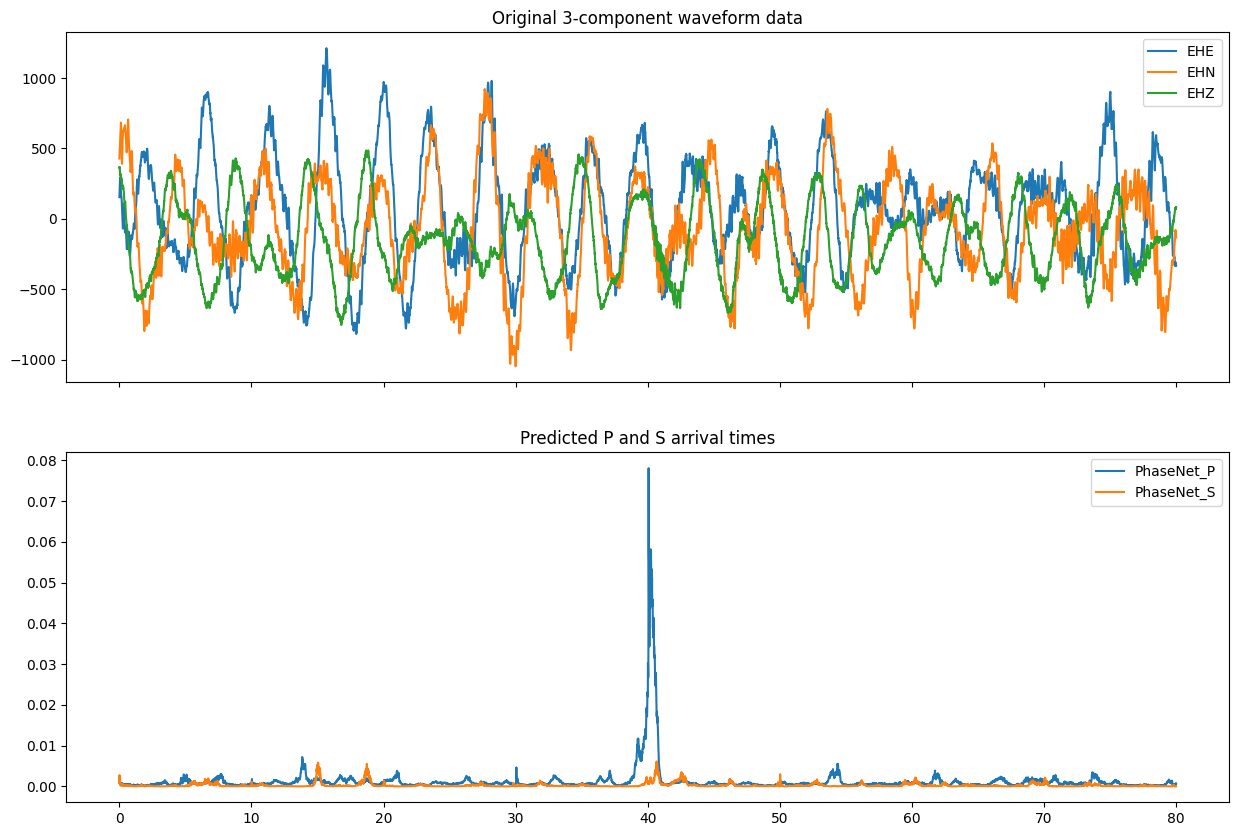

In [194]:
new_annotations = pretrained_model_after.annotate(stream_test, overlap=2000)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.2})

offset = new_annotations[0].stats.starttime - stream_test[0].stats.starttime
for i in range(3):
    # Plot the original stream data
    axs[0].plot(stream_test[i].times(), stream_test[i].data, label=stream_test[i].stats.channel)
    if new_annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        # Plot the annotated data: Predicted P and S arrival times
        axs[1].plot(new_annotations[i].times() + offset, new_annotations[i].data, label=new_annotations[i].stats.channel)

axs[0].legend()
axs[0].set_title("Original 3-component waveform data")
axs[1].legend()
axs[1].set_title("Predicted P and S arrival times")

### 6. Validation

In [ ]:
sample_after = val_generator_after[5]

fig = plt.figure(figsize=(15, 10))
# Note: "hspace" is the amount of height reserved for space between subplots
axs = fig.subplots(3, 1, sharex=True, 
                   gridspec_kw={"hspace": 0.2, "height_ratios": [3, 1, 1]})
axs[0].plot(sample_after["X"].T)
axs[0].set_title("Original 3-component waveform data\n Blue: P-wave, Orange: S-wave, Green: Noise")
axs[1].plot(sample_after["y"].T)
axs[1].set_title("True labels (P, S, Noise)")

# Predict the labels
model_after.eval()  # close the model for evaluation
with torch.no_grad():
    pred = model_after(torch.tensor(sample_after["X"], device=model_after.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)
axs[2].set_title("Predicted labels (P, S, Noise)")